# A notebook to carry out calculations

This notebook accompanies the work described in the article **An evolutionary game theory model for devaluing rhinos**.
It is used for generating plots and analysing data and verify some of the algebra, all described in the paper.

In [1]:
import sympy as sym
import scipy as sp
import numpy as np
sym.init_printing()

import imp
tools = imp.load_source('tools', '../tools.py')

assert sym.__version__ == "1.0"
assert sp.__version__ == "0.19.0"
assert np.__version__ == "1.12.1"

In [2]:
#import matplotlib
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

font = {'size'   : 15,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [3]:
from scipy.optimize import brentq
from scipy.integrate import odeint

Defining all our variables (with assumption that they are positive).

In [4]:
r, s, x, theta_r, alpha, H, beta, gamma, F = sym.symbols("r, s, x, theta_r, alpha, \
                                                          H, beta, gamma, F", positive=True)

The model
----------

In [5]:
# the theta function
tools.theta(r, s)

In [6]:
# the psi function
tools.psi(r, s)

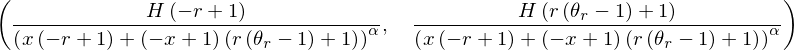

In [7]:
# gain
tools.gain(1), tools.gain(0)

In [8]:
rs = np.linspace(0, 0.999, 100)

In [9]:
gain = sym.lambdify((H, r, theta_r, s, alpha), 
                    H * tools.theta(r=r, s=s, theta_r=theta_r) ** -alpha)

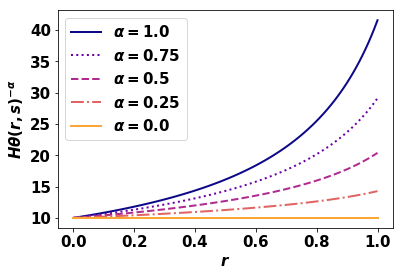

In [10]:
fig =  plt.figure();     
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-']
for i, alphas in enumerate(np.linspace(1, 0, 5)):
    ys = [gain(10, rval, 0.3, 0.2, alphas) for rval in rs]
    c = next(colors)
    
    plt.plot(rs, ys, label=r'$\alpha={}$'.format(alphas), linestyle=linestyles[i], 
             linewidth=2, color=c)
plt.ylabel(r'$H\theta(r, s)^{-\alpha}$')
plt.xlabel(r'$r$')

plt.legend()
plt.savefig('../images/gain_curve.pdf', bbox_inches='tight')

In [11]:
cost = sym.lambdify((F, s, gamma, beta, r), F * (1 - r * s) ** gamma * (1 - r) ** beta)

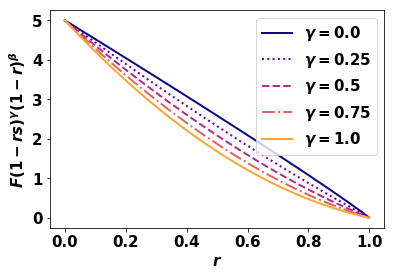

In [12]:
fig =  plt.figure()    
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-']
for i, gammas in enumerate(np.linspace(0, 1, 5)):
    ys = [cost(5, 0.7, gammas, 0.95, rval) for rval in rs]
    c = next(colors)
    
    plt.plot(rs, ys, label=r'$\gamma={}$'.format(gammas), linestyle=linestyles[i], 
             linewidth=2, color=c)
plt.ylabel(r'$F (1 - rs) ^{\gamma} (1 - r) ^{\beta}$')
plt.xlabel(r'$r$')
    
plt.legend()
plt.savefig('../images/gammas_curve.pdf', bbox_inches='tight')

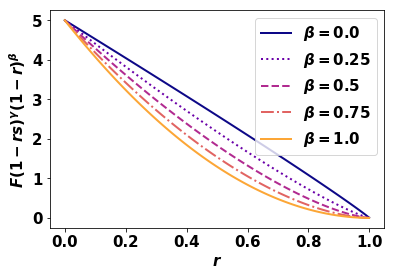

In [13]:
fig =  plt.figure()    
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-']
for i, betas in enumerate(np.linspace(0, 1, 5)):
    ys = [cost(5, 1, 0.95, betas, rval) for rval in rs]
    c = next(colors)
    
    plt.plot(rs, ys, label=r'$\beta={}$'.format(betas), linestyle=linestyles[i], 
             linewidth=2, color=c)
plt.ylabel(r'$F (1 - rs) ^{\gamma} (1 - r) ^{\beta}$')
plt.xlabel(r'$r$')
    
plt.legend()
plt.savefig('../images/betas_curve.pdf', bbox_inches='tight')

Utility
-------

One the cost and the gain of a poacher have been defined we bring all together in the utility function.

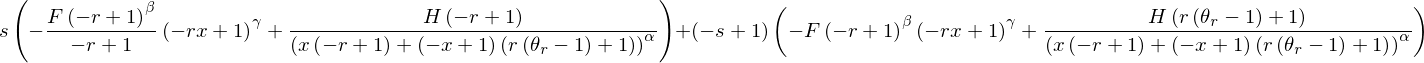

In [14]:
tools.utility()

Here we verify that how we write the utility in the paper is in line with our code.

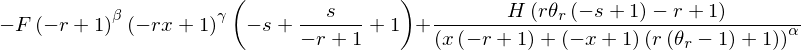

In [15]:
expr = H * (theta_r * r * (1 - s) - r + 1) * tools.theta(r, x) ** (-alpha) - \
       F * (1 - r * x) ** gamma * ((1 - r) ** beta * (-s + s/(1 -r) + 1))
expr

In [16]:
(tools.utility() - expr).simplify()

# All poachers are selective \(s=1\),
is an unstable strategy.



The condition is:
    
$$u(1, 1) > u(0, 1)$$

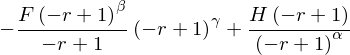

In [17]:
tools.utility(1, 1)

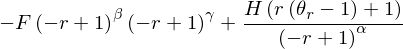

In [18]:
tools.utility(0, 1)

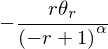

In [19]:
rhs = sym.Poly(tools.utility(1, 1), H).coeffs()[0] - sym.Poly(tools.utility(0, 1), H).coeffs()[0]
rhs

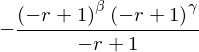

In [20]:
sym.Poly(tools.utility(1, 1), F).coeffs()[0]

In [21]:
rhs = (sym.Poly(tools.utility(1, 1), F).coeffs()[0] - sym.Poly(tools.utility(0, 1), F).coeffs()[0]).simplify()
rhs

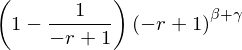

In [22]:
expr = (1 - 1 / (1 - r)) * (1 - r) ** (beta + gamma)
expr

In [23]:
(expr - rhs).simplify()

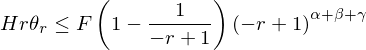

In [24]:
tools.stable_selective_condition()

Being selective is not stable. Because the lefh hand size is always negative and the right hand side is always
positive. Thus the condition rhs < lhs does not hold.

# All poachers are indiscriminate \(s=0\),

is an evolutionary stable strategy.

The condition is:

$$u(0, x_\epsilon) > u(x_\epsilon, x_\epsilon)$$

Let the difference be denoted as $\delta$:

$$\delta = u(0, x_\epsilon) - u(x_\epsilon, x_\epsilon)$$

In [25]:
x_e = sym.symbols("x_epsilon")

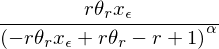

In [26]:
lhs = sym.Poly(tools.utility(0, x_e), H).coeffs()[0] - sym.Poly(tools.utility(x_e, x_e), H).coeffs()[0]
lhs

In [27]:
rhs = (sym.Poly(tools.utility(0, x_e), F).coeffs()[0] - sym.Poly(tools.utility(x_e, x_e), F).coeffs()[0]).simplify()
rhs

In order for the difference to be greater than zero:

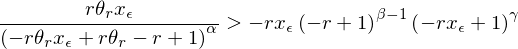

In [28]:
lhs > rhs * -1

Note that the denominator of the lhs is $\theta(r, x_\epsilon)$ which is always positive and the numerator of
the lhs is always positive.

The rhs can be re-written as:

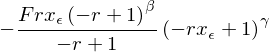

In [29]:
expr = F * (1 - r * x_e) ** gamma * (1 - r) ** beta * x_e * (-r / (1 - r))
expr 

In [30]:
(expr - rhs * F * -1).simplify()

The rhs is always negative.

Being indiscriminate is evolutionary stable. Because left hand side is once again always negative and the right hand side is also positive. Thus the condition rhs > lhs always holds.

# Mixed population of selective and indiscriminate poachers,

is never stable.

The condition is:

$$u(1,s^*) = u(0,s^*)$$

In [31]:
s_star = sym.symbols("s^*")

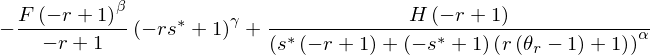

In [32]:
tools.utility(1, s_star)

Note that the denominator of the second term is just, $\theta(r, s^*) ^{\alpha}$.

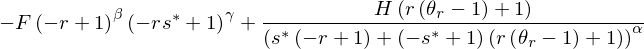

In [33]:
tools.utility(0, s_star)

Similar for the denominator of the second term here.

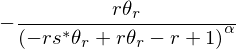

In [34]:
gain_terms = sym.Poly(tools.utility(1, s_star), H).coeffs()[0] - sym.Poly(tools.utility(0, s_star), H).coeffs()[0]
gain_terms

In [35]:
cost_terms = (sym.Poly(tools.utility(1, s_star), F).coeffs()[0] - sym.Poly(tools.utility(0, s_star), F).coeffs()[0]).simplify()
cost_terms

The gain term is multipied by $H$ and the cost term multiplies by $F$, both positive number, thus both terms remain negative.

In order for a mixed strategy to be stable the sum of these two terms must be zero. But the sum
of two negative number is never zero.

Study evolutionary stability using the underlying differential equations
-------------------------------------------------------------------------------------

We define the differential equations.

In [36]:
def dx(x_1, t, F_v, H_v, r_v, alpha_v, beta_v, gamma_v, theta_r_v):
    """
    Define the derivate of x
    """
    f_1 = tools.utility(s=1, x=x_1, F=F_v, H=H_v, r=r_v,
                        alpha=alpha_v, beta=beta_v, gamma=gamma_v, theta_r=theta_r_v)
    f_2 = tools.utility(s=0, x=x_1, F=F_v, H=H_v, r=r_v,
                        alpha=alpha_v, beta=beta_v, gamma=gamma_v, theta_r=theta_r_v)
    
    return x_1 * (1 - x_1) * (f_1 - f_2)

We explore three different scenarios.

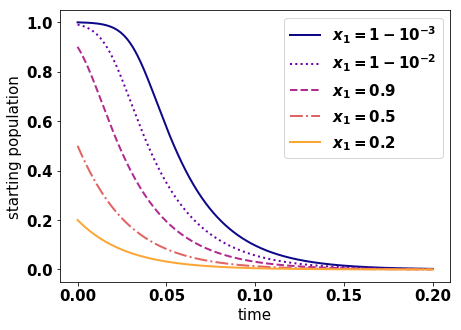

In [37]:
ts = np.linspace(0, .2, 1000)
epsilon = 10 ** -2
fig =  plt.figure(figsize=(7, 5))    
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-', ':']
starting_populations = [.2, .5, .9, .99, .999][::-1]
labels = ["0.2", "0.5", "0.9", "1-10^{-2}", "1-10^{-3}"][::-1]
for linestyle, starting_population, label in zip(linestyles, 
                                                 starting_populations,
                                                 labels):

    xs = odeint(func=dx, y0=[starting_population], t=ts, args=(5, 50, 0.65, 2, 2, 1, 0.6))
    c = next(colors)
    
    plt.plot(ts, xs, linestyle=linestyle, linewidth=2, color=c, label=r'$x_1={}$'.format(label));
    
plt.ylabel(r'starting population')
plt.xlabel(r'time')

plt.xticks()
    
plt.legend()
plt.savefig('../images/IndiscriminateESS.pdf', bbox_inches='tight')

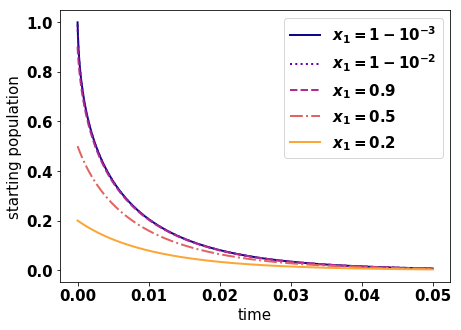

In [38]:
ts = np.linspace(0, .05, 1000)
epsilon = 10 ** -2
fig =  plt.figure(figsize=(7, 5))    
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-', ':']
starting_populations = [.2, .5, .9, .99, .999][::-1]
labels = ["0.2", "0.5", "0.9", "1-10^{-2}", "1-10^{-3}"][::-1]
for linestyle, starting_population, label in zip(linestyles, 
                                                 starting_populations,
                                                 labels):

    xs = odeint(func=dx, y0=[starting_population], t=ts, args=(5, 50, 0.99, 2, 2, 1, 0.6))
    c = next(colors)
    
    plt.plot(ts, xs, linestyle=linestyle, linewidth=2, color=c, label=r'$x_1={}$'.format(label));
    
plt.ylabel(r'starting population')
plt.xlabel(r'time')

plt.xticks()
    
plt.legend()
plt.savefig('../images/IndiscriminateESS-high-r.pdf', bbox_inches='tight')

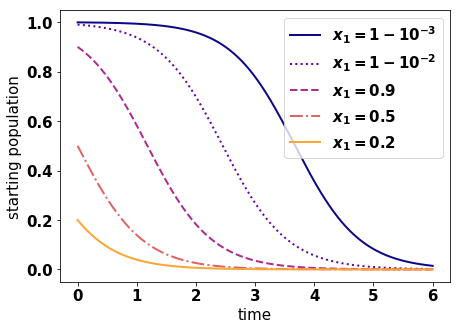

In [39]:
ts = np.linspace(0, 6, 1000)
epsilon = 10 ** -2
fig =  plt.figure(figsize=(7, 5))    
colors = iter(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = ['-', ':', '--', '-.', '-', ':']
starting_populations = [.2, .5, .9, .99, .999][::-1]
labels = ["0.2", "0.5", "0.9", "1-10^{-2}", "1-10^{-3}"][::-1]
for linestyle, starting_population, label in zip(linestyles, 
                                                 starting_populations,
                                                 labels):

    xs = odeint(func=dx, y0=[starting_population], t=ts, args=(5, 50, 0.05, 2, 2, 1, 0.6))
    c = next(colors)
    
    plt.plot(ts, xs, linestyle=linestyle, linewidth=2, color=c, label=r'$x_1={}$'.format(label));
    
plt.ylabel(r'starting population')
plt.xlabel(r'time')

plt.xticks()
    
plt.legend()
plt.savefig('../images/IndiscriminateESS-low-r.pdf', bbox_inches='tight')

Analysis of the generated data.
-------------------------